# Check when model has finished spin up

July, 2019

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.stats as scs

In [2]:
initial = '/data/brogalla/IC/Mn_ini_20180716.nc'
end_yr1 = '/data/brogalla/run_storage/spin-up0/'
end_yr2 = '/data/brogalla/run_storage/spin-up1/'
end_yr3 = '/data/brogalla/run_storage/spin-up2/'
end_yr4 = '/data/brogalla/run_storage/spin-up3/'
fday    = 'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021227-20021231.nc'
monthly =  'ANHA12_EXH006_2002_monthly.nc'

Mask land values

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = tmask[:,:,:,:]

In [8]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
depth = np.array(ref.variables['deptht'])

In [9]:
def load_file(path, ini=False):
    
    file = nc.Dataset(path)
    if ini:
        dmn = np.array(file.variables['dMn'])
        cond = (tmask[0, :, :, :] < 0.1) 
    else:
        dmn  = np.array(file.variables['dissolmn'])
        cond = (tmask[0, :, 1480:2050, 160:800] < 0.1) 
        
    dmn_masked = np.ma.masked_where(cond, dmn[0,:,:,:]) 
    
    return dmn_masked

In [10]:
mn_ini  = load_file(initial, ini=True)
mn_end1 = load_file(end_yr1 + fday)
mn_end2 = load_file(end_yr2 + fday)
mn_end3 = load_file(end_yr3 + fday)
mn_end4 = load_file(end_yr4 + fday)

In [11]:
tmask_full  = np.empty((12,50,570,640))
tmask_full[:] = tmask[0,:,1480:2050,160:800]

In [12]:
cond      = (tmask_full < 0.1) 
mn_m1     = nc.Dataset(end_yr1 + monthly)
mn_month1 = np.ma.masked_where(cond, np.array(mn_m1.variables['dissolmn'][:,0,:,:,:]))
mn_m2     = nc.Dataset(end_yr2 + monthly)
mn_month2 = np.ma.masked_where(cond, np.array(mn_m2.variables['dissolmn'][:,0,:,:,:]))
mn_m3     = nc.Dataset(end_yr3 + monthly)
mn_month3 = np.ma.masked_where(cond, np.array(mn_m3.variables['dissolmn'][:,0,:,:,:]))
mn_m4     = nc.Dataset(end_yr4 + monthly)
mn_month4 = np.ma.masked_where(cond, np.array(mn_m4.variables['dissolmn'][:,0,:,:,:]))

Correlate initial dmn with final dmn:

In [13]:
array_a  = np.ndarray.flatten(mn_ini[:, 1480:2050, 160:800])
array_b1 = np.ndarray.flatten(mn_end1)

In [14]:
array_a_nomask  = array_a[~array_a.mask]
array_b1_nomask = array_b1[~array_b1.mask]

In [15]:
scs.pearsonr(array_a_nomask, array_b1_nomask)

(0.5737249467129834, 0.0)

After one run from 2002-2003, the dissolved Mn field has a correlation of 0.498 with the initial conditions (Pearson R). Submitted a new run which restarts at the end of 2002 and repeats the year 2002.

In [16]:
array_b2 = np.ndarray.flatten(mn_end2)
array_b2_nomask = array_b2[~array_b2.mask]

In [17]:
scs.pearsonr(array_a_nomask, array_b2_nomask)

(0.4815172331547651, 0.0)

In [18]:
array_b3 = np.ndarray.flatten(mn_end3)
array_b3_nomask = array_b3[~array_b3.mask]

In [19]:
scs.pearsonr(array_a_nomask, array_b3_nomask)

(0.41775829094703043, 0.0)

In [20]:
array_b4 = np.ndarray.flatten(mn_end4)
array_b4_nomask = array_b4[~array_b4.mask]

In [21]:
scs.pearsonr(array_a_nomask, array_b4_nomask)

(0.3717851231217234, 0.0)

# Alternate metric

Look at how different the station profiles are after multiple spin-ups. So, for each month in the set, calculate the difference between the profiles. When the difference becomes small, the profiles are most similar and have reached steady-state.

In [22]:
stni = [104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547]
stnj = [370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457]

In [23]:
diff1 = np.empty((12,12))
diff2 = np.empty((12,12))
diff3 = np.empty((12,12))
for i in range(0,len(stni)): # loop over the number of stations
    diff1[i,:] = np.sum(np.abs(mn_month2[:, :, stni[i], stnj[i]] - mn_month1[:, :, stni[i], stnj[i]]), axis=1)
    diff2[i,:] = np.sum(np.abs(mn_month3[:, :, stni[i], stnj[i]] - mn_month2[:, :, stni[i], stnj[i]]), axis=1)
    diff3[i,:] = np.sum(np.abs(mn_month4[:, :, stni[i], stnj[i]] - mn_month3[:, :, stni[i], stnj[i]]), axis=1)

In [24]:
colors=['#124160', '#149e89', '#c4894e', '#97806d', '#541428', '#7d9964', \
       '#9a4571', '#8cd52f', '#ffac44', '#466b94', '#c0d6e4', '#d04538']

name  =['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
       'CB1', 'CB2', 'CB3']

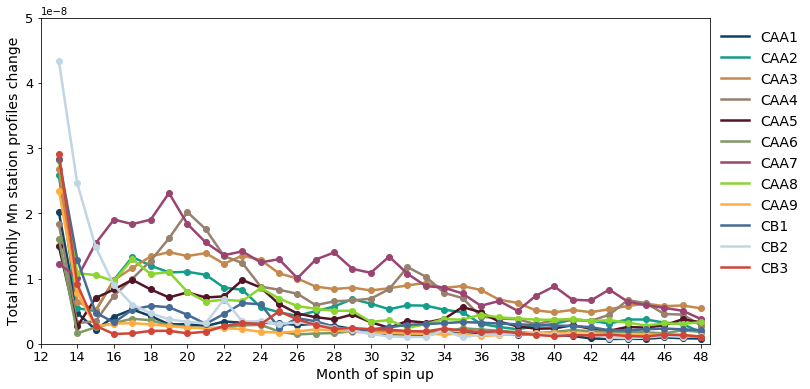

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

for stn in range(0,12):
    ax.plot(range(1+12,37+12), np.append(np.append(diff1[stn,:], diff2[stn,:]), diff3[stn,:]), \
            c=colors[stn], label=name[stn], linewidth=2.5)
    ax.plot(range(1+12,37+12), np.append(np.append(diff1[stn,:], diff2[stn,:]), diff3[stn,:]), '.', \
            markersize=12, c=colors[stn])

ax.set_xlim([12.5, 48.5])
ax.set_ylim([0, 5e-8])
ax.xaxis.set_ticks(np.arange(12, 38+12, 2))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('Month of spin up', fontsize=14)
ax.set_ylabel('Total monthly Mn station profiles change', fontsize=14)
#$ \sum_{z}\ Mn(z, month, yr) - Mn(z, month, yr-1)$
ax.legend(bbox_to_anchor=(1.15, 1.00), fontsize=14, frameon=False)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn_spin-up-reference-20190917.png', bbox_inches='tight')

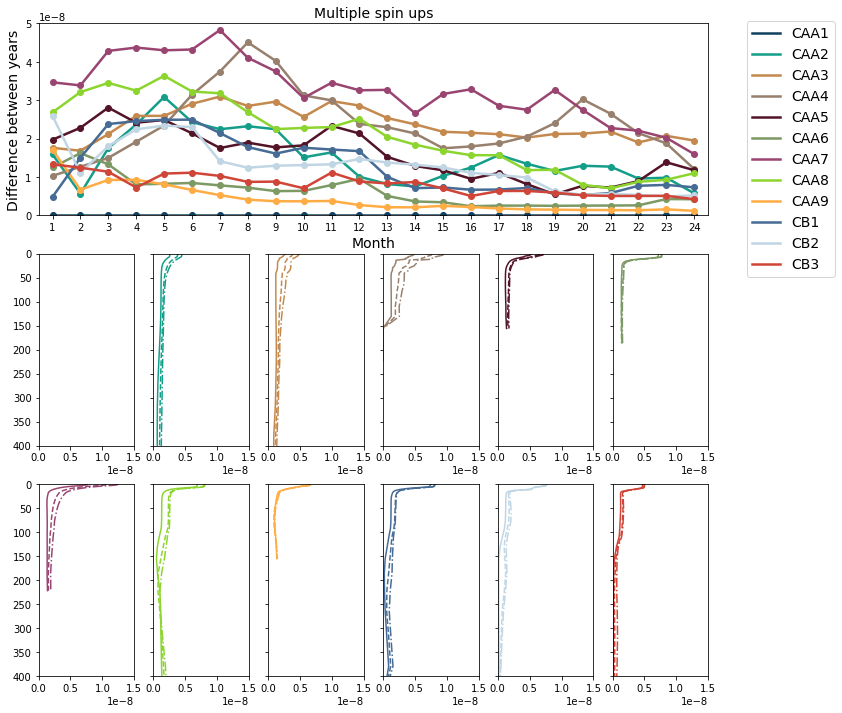

In [24]:
fig = plt.subplots(figsize=(12,12))

ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=6)
ax2 = plt.subplot2grid((3, 6), (1, 0))
ax3 = plt.subplot2grid((3, 6), (1, 1))
ax4 = plt.subplot2grid((3, 6), (1, 2))
ax5 = plt.subplot2grid((3, 6), (1, 3))
ax6 = plt.subplot2grid((3, 6), (1, 4))
ax7 = plt.subplot2grid((3, 6), (1, 5))

ax8 = plt.subplot2grid((3, 6), (2, 0))
ax9 = plt.subplot2grid((3, 6), (2, 1))
ax10 = plt.subplot2grid((3, 6), (2, 2))
ax11 = plt.subplot2grid((3, 6), (2, 3))
ax12 = plt.subplot2grid((3, 6), (2, 4))
ax13 = plt.subplot2grid((3, 6), (2, 5))

# top plot:
ax3.yaxis.set_ticklabels([]); ax4.yaxis.set_ticklabels([]); ax5.yaxis.set_ticklabels([]);
ax6.yaxis.set_ticklabels([]); ax7.yaxis.set_ticklabels([]); ax9.yaxis.set_ticklabels([]);
ax10.yaxis.set_ticklabels([]); ax11.yaxis.set_ticklabels([]); ax12.yaxis.set_ticklabels([]);
ax13.yaxis.set_ticklabels([])

for stn in range(0,12):
    ax1.plot(range(1,25), np.append(diff1[stn,:], diff2[stn,:]), \
            c=colors[stn], label=name[stn], linewidth=2.5)
    ax1.plot(range(1,25), np.append(diff1[stn,:], diff2[stn,:]), '.', \
            markersize=12, c=colors[stn])

ax1.set_xlim([0.5, 24.5])
ax1.set_ylim([0, 5e-8])
ax1.xaxis.set_ticks(np.arange(1, 25, 1))
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Difference between years', fontsize=14)
ax1.set_title('Multiple spin ups', fontsize=14)
ax1.legend(bbox_to_anchor=(1.20, 1.05), fontsize=14)

#Other plots:
stn=0
for ax in [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]:
    ax.invert_yaxis()
    ax.set_ylim([400, 0])
    ax.set_xlim([0, 15e-9])

    mth=7
    ax.plot(mn_month1[mth,:,stni[stn], stnj[stn]], depth, c=colors[stn])
    ax.plot(mn_month2[mth,:,stni[stn], stnj[stn]], depth, '--', c=colors[stn])
    ax.plot(mn_month3[mth,:,stni[stn], stnj[stn]], depth, '-.', c=colors[stn])
    
    stn+=1